* A formula of search is applied to OpenAlex to extract an equivalent database
* We load the inspire papers and extract the dois from the `recid`s
* We extract of the dois from the results in OpenAlex and compare with the dois from inspire:
  * `DD`: inspire dois
  * `FF`: OpenAlex dois
  * `FF-DD`: dois only in OpenAlex: see [Status analysis](#Status-analysis): `status` values are:
     * valid arXiv dois without extra dois: with `status['status'] = 'ok'` and `published = False`
     * new valid dois with `status['status'] = 'ok'` with `status['affiliations_in_inspire'] = False`,  `status['date_range'] = 'outside'`, `status['mathching_inspire_authors']`. The first fixes missing affiliations, the second may be outside the date range, the third are not in inspire but have inspire authors
     * duplicated entries in OpenAlex with `status in ['duplicated', 'duplicated_dois']`
     * erros in OpenAlex with `status in [wrong_countries, wrong_doi]`. The first are bad affilitions, the second is not the real doi 
     * extra works that maybe are outside the scope of inspire with `status = 'not_inspire_scope'`
     * `status = 'erratum_or_arxiv_doi'` ?
    * `DD-FF`: dois inly in inspire:
     * Not found in the OpenAlex search formula because:
       * Missing or wrong affilitions in OpenAlex
       * Greater publication year that inspire cut of July 2022. In inspire the `publication_year` count as arXiv preprint year
       * topic assignation

## Results
### TOTAL:
* 11856 dois not in the INSPIREHEP-LA database →:
### In the scope of inspire
  * 8205 with `'status' == ok` but the proper doi was not captured because → :
      * 4487 in INSPIREHEP → :
          * 3553 works with missing affiliations in inspire but with LA aff in OA (inspire error)
          * 931 works with affiliations in inspire →:
              * 481 arxiv works which have not doi in inspire-hep (not published or published in journal without doi)
              * 450 published with inspire affiliations →:
                  * 377 of `year >= 2022` (not covered in the initial selection)
                  * 42 erratum dois (counts separatly in OpenAlex)
                  * 34 unknown 
          * 3 with mising authors in inspire: `None` affiliations in inspire
      * 3718 not in INSPIREHEP but with INSPIREHEP-LA authors accordinf to OpenAlex (in the scope of inspire)
  * 817 with wrong country assignation in OpenAlex
  * 513  arxiv works which are duplicated in OpenAlex to other works with doi in the INSPIREHEP-LA database
  * 200 doi works which are duplicated in OpenAlex to other works with doi in the INSPIREHEP-LA database
### Not in the scope of inspire
  * 2121 not in INSPIRE scope


affiliations_in_inspire
False    3553
True      931
None        3

In [1]:
import pandas as pd

In [2]:
results = pd.DataFrame([{'Type': 'Intersection INSPIRE-HEP-LA OpenAlex', 'Works count': 27138},
              {'Type': 'Missing affiliation in INSPIRE-HEP-LA', 'Works count':3553 },
              {'Type': 'Not in INSPIRE-HEP but with INSPIRE-HEP-LA authors', 'Works count': 3718 },
              {'Type': 'In not-LA INSPIRE-HEP but with wrong LA-affiliation in OpenAlex', 'Works count': 817},
              {'Type': "arXiv DOIs in OpenAlex which are duplicated to DOIs in 1.", 'Works count': 513 },
              {'Type': 'arXiv DOIs in OpenAlex unpublished in INSPIRE-HEP-LA', 'Works count': 481 },
              {'Type': 'Outside published range of INSPIRE-HEP-LA', 'Works count': 377 },
              {'Type': "Duplicated DOIs in OpenAlex corresponding to a work with two DOIs in INSPIRE-HEP-LA", 'Works count': 200 },
              {'Type': 'Independent erratum DOI in OpenAlex and two DOIS in INSPIRE-HEP-LA', 'Works count':42 },
              {'Type': 'Others', 'Works count': 35},
              {'Type': 'Not in the scope of INSPIRE-HEP-LA', 'Works count': 2121 }
             ])

In [3]:
results['Works count'].sum()

38995

In [4]:
TOTAL = results['Works count'].sum()
results['\%'] = results['Works count'].apply(lambda x: round(x/TOTAL*100,1))
results['index'] = [f"{x+1})" for x in results.index]
with open('results.tex','w') as f:
    f.write(results[['index', 'Type', 'Works count', '\%']].to_latex(index=False))

In [5]:
results['\%'].sum()

99.89999999999998

## Generate datasets

In [6]:
latin_america_countries = {
    "Argentina": "AR",
    "Bolivia": "BO",
    "Brazil": "BR",
    "Chile": "CL",
    "Colombia": "CO",
    "Costa Rica": "CR",
    "Cuba": "CU",
    "Dominican Republic": "DO",
    "Ecuador": "EC",
    "El Salvador": "SV",
    "Guatemala": "GT",
    "Haiti": "HT",
    "Honduras": "HN",
    "Mexico": "MX",
    "Nicaragua": "NI",
    "Panama": "PA",
    "Paraguay": "PY",
    "Peru": "PE",
    "Uruguay": "UY",
    "Venezuela": "VE"
}
#    "Puerto Rico": "PR",

In [7]:
import requests
import json
import time
import gzip

In [8]:
LA = []
next_cursor = "*"
p = 200
TOPICS = 't10048|t10224|t10527|t10921|t11090|t10025|t10095|\
t11415|t11044|t11367|t10463'

COUNTRIES = 'countries/ar|countries/bo|countries/br|countries/cl|\
countries/co|countries/cr|countries/cu|countries/do|countries/ec|\
countries/sv|countries/gt|countries/hn|countries/mx|countries/pa|\
countries/py|countries/pe|countries/uy|countries/ve'


In [9]:
url_topics = f"https://api.openalex.org/works?page=1&filter=topics.id:{TOPICS},\
authors_count:1-10,authorships.countries:{COUNTRIES},publication_year:1900-2022&\
sort=cited_by_count:desc&per_page={p}&cursor={next_cursor}"    


In [10]:
loop = False
while loop:
    url_topics = f"https://api.openalex.org/works?page=1&filter=topics.id:{TOPICS},\
authors_count:1-10,authorships.countries:{COUNTRIES},publication_year:1900-2022&\
sort=cited_by_count:desc&per_page={p}&cursor={next_cursor}"    
    #url_topics = f"https://api.openalex.org/works?page=1&filter=authorships.author.id:a5049648126&sort=cited_by_count:desc&per_page=200&cursor={next_cursor}"
    
    j = requests.get(url_topics)
    time.sleep(0.1)

    
    la = j.json()
    
    la_meta = la.get('meta')
    next_cursor = la_meta.get('next_cursor')
    
    if not next_cursor:
        #break
        print('stop')
        break
    
    LA = LA + la.get('results')
    print(len(LA),end='\r')

In [11]:
if loop:
    with gzip.open("data/openalex_topics.json.gz", 'w') as fout:
        fout.write(json.dumps(LA).encode('utf-8'))     

In [12]:
with gzip.open("openalex_topics.json.gz", 'r') as fin:
    LA = json.loads(fin.read().decode('utf-8'))

In [13]:
# too large: 1.2GB, try to use the recids file below
if loop:
    f = 'data/papers.json'
    with open(f, 'r') as file:
        data = json.load(file)

In [14]:
import pandas as pd

In [15]:
if loop:
    inspa = pd.DataFrame(data)
    
    del data
    
    recids =inspa['recid'].unique()
    len(recids)
    
    recids = [int(x) for x in recids]

    del inspa

    with open('data/recids.json','w') as f:
        json.dump(recids,f)

In [16]:
with open('data/recids.json','r') as f:
    recids = json.load(f)

In [17]:
len(recids)

49181

In [18]:
393487 in recids

True

In [19]:
#list(recids).index(393487)

In [20]:
#recids = recids[32287:32288]

In [21]:
loop = False
if loop:
    dois = []
    for x in list(range(0,len(L)+1,80))[1:]:
        time.sleep(0.1)
        print(f"{x-80}:{x}",end='\r')
    
        q='%20or%20'.join([ f"recid:{x}" for x in recids[x-80:x]])
        
        url = f"https://inspirehep.net/api/literature?size=100&page=1&q={q}&fields=dois"
        time.sleep(0.1)
        
        jj = requests.get(url)
        
        try:
            LL = jj.json().get('hits').get('hits')
        except:
            LL = []
        
        if not LL:
            continue
            
        tmp = pd.DataFrame(LL)
        tmp['control_number'] = tmp['metadata'].str['control_number']
        tmp['doi'] = tmp['metadata'].str['dois'].str[0].str['value']
        dois = dois + tmp[['control_number','doi']].dropna().to_dict(orient='records')
        #break

In [22]:
if loop:
    with open("data/inspire_dois.json", "w") as json_file:
        json.dump(dois, json_file)

In [23]:
with open("data/inspire_dois.json", "r") as json_file:
    dois = json.load(json_file)

In [24]:
di = pd.DataFrame(dois)

In [25]:
di['doi'] = di['doi'].str.lower()

In [26]:
di['doi'].shape[0], di['doi'].unique().shape

(38713, (38713,))

In [27]:
df = pd.DataFrame(LA)

In [28]:
del LA

In [29]:
df.shape

(41731, 50)

In [30]:
len(df['primary_topic'].str['display_name'].unique())

274

In [31]:
topics = url_topics.split('topics.id:')[-1].split(',')[0].split('|')
topics = [t.lower() for t in topics]

In [32]:
df['topics'].apply(lambda L: [f"{d.get('display_name')} ({d.get('id').split('/')[-1].lower()})"  for d in L if d.get('id').split('/')[-1].lower() in topics] ).str[0].unique()

array(['Cosmology and Gravitation Theories (t10095)',
       'Black Holes and Theoretical Physics (t10025)',
       'Noncommutative and Quantum Gravity Theories (t11415)',
       'Particle physics theoretical and experimental studies (t10048)',
       'High-Energy Particle Collisions Research (t10527)',
       'Dark Matter and Cosmic Phenomena (t11090)',
       'Pulsars and Gravitational Waves Research (t10463)',
       'Neutrino Physics Research (t10921)',
       'Quantum Chromodynamics and Particle Interactions (t10224)',
       'Particle accelerators and beam dynamics (t11367)',
       'Particle Detector Development and Performance (t11044)'],
      dtype=object)

In [33]:
def topics_score(L,topics,score = 0):
    LL = []
    for d in L:
        if d['id'].split('/')[-1].lower() in topics and d['score'] >= score:
            LL.append(d)
    return LL

In [34]:
score = 0.9
df = df[df['topics'].apply(lambda L: topics_score(L,topics,score=score)).apply(len)> 0].reset_index(drop=True)
df.shape

(41349, 50)

In [35]:
df['doi'] = df['doi'].str.lower().str.split('https://doi.org/').str[-1]
df['doi'].shape,df['doi'].dropna().shape,df['doi'].dropna().unique().shape

((41349,), (38997,), (38995,))

In [36]:
df['countries'] = df['authorships'].apply(lambda L: [d.get('countries') for d in L]
                       ).apply(lambda L: 
        list(set([item for sublist in L for item in sublist])))


In [37]:
CC = []
for country in latin_america_countries:
    country_code = latin_america_countries[country]
    d = { 'country': country,
        'country_code': country_code, 
        'cited_by_count':int(df[df['countries'].apply(
            lambda L: country_code in L)]['cited_by_count'].sum())}
    CC.append(d)

In [38]:
%matplotlib inline

In [39]:
import matplotlib.pyplot as plt

In [40]:
with open('all_citations_total_oa.json','w') as f:
    json.dump(CC,f)

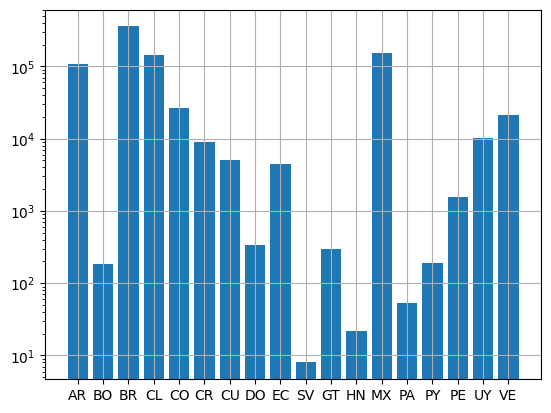

In [41]:
plt.bar([d.get('country_code') for d in CC if d.get('cited_by_count') > 0],
          [d.get('cited_by_count') for d in CC if d.get('cited_by_count') > 0])
plt.semilogy()
plt.grid()
plt.savefig('citation_count_by_OA.pdf')

In [42]:
DD = di['doi'].dropna().to_list() # dois in inspire (missing dois if duplicates)
FF = df['doi'].dropna().to_list() # dois in OpenAlex

In [43]:
'10.1016/j.nuclphysb.2018.12.017' in DD

False

In [44]:
len(DD)

38713

In [45]:
len(FF)

38997

In [46]:
intersection = list(set(DD).intersection( FF ))
len(intersection) # In both inspire and OpenAlex

27138

In [47]:
dfa = df[df['doi'].apply(lambda d: d in intersection)].reset_index(drop=True)
authors = dfa['authorships'].apply(lambda L: [d.get('author').get('id').split('/')[-1] for d in L] )
authors = list(set([item for sublist in authors for item in sublist]))
len(authors) #authors both in inspire and OpenAlex

15527

In [48]:
DDD = list(set(DD).difference( FF  ))
FFF = list(set(FF).difference(DD))

In [49]:
len(DDD) # only inspire

11575

In [50]:
with open('DDD.json','w') as f:
    json.dump(DDD,f)

In [51]:
len(FFF) # only OpenAlex

11857

In [52]:
df[df['doi'].astype(str).str.contains('arxiv')].shape # OpenAlex works in arXiv only 

(1277, 51)

In [53]:
trueFF = df[df['primary_location'].str['source'].str['issn_l'].apply(lambda s: s is not None)]['doi'].dropna().to_list()

In [54]:
len(trueFF),len(FF)

(35136, 38997)

In [55]:
trueFFF = list(set(trueFF).difference(DD))

In [56]:
len(trueFFF)

8941

In [57]:
del df

In [58]:
del dfa

In [59]:
def get_inspire(url):
    jj = requests.get(url)
        
    try:
        LL = jj.json().get('hits').get('hits')
    except:
        LL = []

    return LL
    
def clean_dois(dois):
    return [d for d in dois if d.get('source') != 'arXiv' and d.get('material') != 'erratum']



def get_authors(doi,authors):
    status = {}
    url = f"https://api.openalex.org/works?filter=doi:{doi}"
    jj = requests.get(url)
    time.sleep(0.1)
    if jj.status_code == 200 and jj.json().get('meta') and jj.json().get('meta').get('count'):
        try:
            au = [ d.get('author').get('id').split('/')[-1] for d in jj.json().get('results')[0].get('authorships')]
        except:
            au = []
        auint = list(set(au).intersection(authors))    
        if len(auint) > 0:
            status = { 'status': 'ok',
                       'mathching_inspire_authors': True,
                       'mathching_inspire_author_ids': auint,
                       'doi': doi}
        else: # outside inspire
            status = { 'status': 'not_inspire_scope', 
                       'mathching_inspire_authors': False,
                       'mathching_inspire_author_ids': [],
                       'doi': doi}
    return status

In [60]:
no_issn_dois = list(set(FFF).difference(trueFFF)) # doi not relate to journals with issns
no_issn_dois[0:15]

['10.48550/arxiv.1111.1034',
 '10.1142/9789812773951_0018',
 '10.2172/6110556',
 '10.48550/arxiv.1405.6638',
 '10.1142/9789811258251_0049',
 '10.48550/arxiv.gr-qc/0111010',
 '10.48550/arxiv.astro-ph/0611368',
 '10.1017/9781108569392.028',
 '10.48550/arxiv.1308.2079',
 '10.1109/imoc.2011.6169395',
 '10.48550/arxiv.gr-qc/0201101',
 '10.48550/arxiv.gr-qc/0204024',
 '10.1017/cbo9781316090954.026',
 '10.22323/1.385.0017',
 '10.21468/scipost.report.3803']

## Status analysis

### General definitions

In [61]:
2151035 not in recids

True

In [62]:
def get_year(arxiv_doi):
    arxiv_id =arxiv_doi.split('/')
    if len(arxiv_id) == 2:
        year = eval('20'+arxiv_id[-1].split('arxiv.')[-1][:2])
    elif len(arxiv_id) == 3:
        year = arxiv_id[-1][:2]
        if year[0] == '0':
             year = eval('20' + year)
        else:
            year = eval('19' + year)
    
    return year

In [63]:
max_year = 2022
arxiv_doi = '10.48550/arxiv.0801.2559'
arxiv_doi = '10.48550/arxiv.astro-ph/9505300'
arxiv_doi = '10.48550/arxiv.astro-ph/0505300'
get_year(arxiv_doi)

2005

In [64]:
doi = '10.1088/1742-6596/590/1/012008'
doi =  '10.48550/arxiv.0801.2559'
#doi = '10.1103/physrevd.93.124020'
#doi = '10.48550/arxiv.astro-ph/0505300' # test: not_doi
#doi = '10.48550/arxiv.1909.10299' # test: duplicated
#doi = '10.1007/s100520050258' # test: duplicated_dois
#doi = '10.1140/epjc/s10052-015-3288-x' # test: right_countries
#doi = '10.1007/bf02817915' # test: wrong_countries
doi = '10.24275/uami.gq67jr29s' # test: 'mathching_inspire_authors' and 'status': 'not_inspire_scope'
doi = '10.1016/0003-4916(82)90173-7' # test matching_authors
doi = '10.1063/1.2710571' # test wrong_affiliations
doi = '10.1016/0550-3213(95)00620-6' # test duplicated dois
#doi = '10.1088/1742-6596/590/1/012008' #test
#doi = '10.1140/epjc/s10052-022-11127-w' # test outside_range
#doi = '10.1007/bf00762333' # test 'mathching_inspire_authors'

In [65]:
def check_doi(doi, recids, DD, authors, max_year):
    url = f"https://inspirehep.net/api/literature?q=doi:{doi}&fields=control_number,authors,dois,publication_info"
    LL = get_inspire(url)
    time.sleep(0.1)

    
    status = {'doi':doi,'in_inspire': False}
    arxiv_doi = None
    if doi.find('/arxiv.') == 8:
        arxiv_doi = doi
    
    status['arxiv_doi'] = arxiv_doi
    
    metadata = None
    if LL:
        metadata = LL[0].get('metadata')
        status['in_inspire'] = True # len(LL) != 0
    inspire_authors = None
    all_dois = None
    control_number = None
    publication_info = None
    if metadata:
        inspire_authors = metadata.get('authors')
        all_dois = metadata.get('dois')
        control_number = metadata.get('control_number')
        publication_info = metadata.get('publication_info')
    
    inspire_dois = []
    status['recid'] = control_number
    status['in_recids'] = False
    status['published'] = True
    status['erratum_doi'] = None
    status['inspire_dois'] = []
    status['new_doi'] = None
    status['oa_errors'] = []
    status['inspire_scope'] = True
    status['new_doi_in_inspire'] = None
    status['affiliations_in_inspire'] = None
    status['mathching_inspire_authors'] = None
    status['mathching_inspire_author_ids'] = None
    status['date_range'] = None
    status['year'] = None
    
    if publication_info:
        try:
            status['year'] = max([d.get('year') for d in publication_info])
        except:
            status['year'] = None
    
    if not status['year'] and status['arxiv_doi']:
        status['year'] = get_year(status['arxiv_doi'])
    
    # chek if already in database
    if control_number and control_number in recids:
        status['in_recids'] = True
    else:
        # check inspire_scope
        pass
    
    # Check if published with doi
    if all_dois:
        erratum_doi = [d for d in all_dois if d.get('material') == 'erratum']
        if erratum_doi:
            status['erratum_doi'] = erratum_doi[0]
        inspire_dois = [d for d in all_dois if d.get('source') != 'arXiv' and d.get('material') != 'erratum']
        status['inspire_dois'] = list(set([d.get('value').lower() for d in inspire_dois]))
    else:
        if status['in_inspire']:
            status['published'] = False
    
    # Analysis
    status['status'] = None
    if status.get('arxiv_doi') and status['inspire_dois']:
        status['new_doi'] = status['inspire_dois'][0]
        status['status'] = 'duplicated'
        status['oa_errors'].append(status['status'])
    else:
        status['status'] = 'ok'
    
    if not status.get('arxiv_doi') and status['inspire_dois']:
        if len(status['inspire_dois']) > 1:
            status['new_doi'] = [x for x in status['inspire_dois'] if x != doi ][0]
            status['status'] = 'duplicated_dois'
            status['oa_errors'].append(status['status'])
    else:
        if not status['oa_errors']:
            status['status'] = 'ok'
    
    if status['new_doi'] and status['new_doi'] in DD:
        status['new_doi_in_inspire'] = True
    else:
        status['new_doi_in_inspire'] = False
    if inspire_authors:
        affiliations = [d for d in inspire_authors if d.get('affiliations')]
        if affiliations: # not affiliations in inspire
            status['affiliations_in_inspire'] = True
        else:
            status['affiliations_in_inspire'] = False
    
    # not in inspire LA database but in inspire → affiliations exist and are not LA
    if status['in_inspire'] and not status['in_recids'] and status['affiliations_in_inspire']:
        # check year conflict
        if status['year'] and status['year'] >= max_year:
            status['status'] = 'ok'
            status['date_range'] = 'outside'
        else:
            status['status'] = 'wrong_countries'
            status['oa_errors'].append(status['status'])
    else:
        if not status['oa_errors']:
            status['status'] = 'ok'
    
    # not in inspire → check for inspire authors
    if not status['in_inspire'] and not status['in_recids']:
        check_status = get_authors(doi,authors)
        status['status'] = check_status['status']
        if status['status'] == 'not_inspire_scope':
            status['oa_errors'].append(status['status'])
        else:
            if not status['oa_errors']:
                status['status'] = 'ok'
            
        status['mathching_inspire_authors'] = check_status['mathching_inspire_authors']
        status['mathching_inspire_author_ids'] = check_status['mathching_inspire_author_ids']
    
    if len(status.get('oa_errors')) > 0:
        status['status'] = status.get('oa_errors')[0]
    return status

In [66]:
#status

In [67]:
#dfa[dfa['authorships'].apply(lambda L: [d.get('author').get('id').split('/')[-1] for d in L] ).apply(lambda L: 'A5058759801' in L)]

In [68]:
#check_doi(doi,recids, DD, authors, max_year)

### Only OpenAlex

In [69]:
if loop:
    ST = []
    i = 0
    for doi in FFF:
        status = {}
        i += 1
        print(str(i).zfill(5),end='\r',flush=True)
        status = check_doi(doi,recids, DD, authors, max_year)
        ST.append(status)

In [70]:
if loop:
    with open('data/only_openalex.json','w') as f:
        json.dump(ST,f)

In [71]:
with open('data/only_openalex.json','r') as f:
    ST = json.load(f)

In [72]:
len(FFF)

11857

In [73]:
import pandas as pd

In [74]:
ST = pd.DataFrame(ST)

In [75]:
len(DDD)

11575

In [76]:
def fix_status_ok(oa_errors,status):
    if len(oa_errors) > 0:
        status = oa_errors[0]
    return status

In [77]:
ST['status'] = ST.apply(lambda d: fix_status_ok(d['oa_errors'],d['status']), axis='columns')

In [78]:
ST[ST['oa_errors'].apply(len)>0]['status'].value_counts()#.sum()

status
not_inspire_scope    2121
wrong_countries       817
duplicated            513
duplicated_dois       200
Name: count, dtype: int64

In [79]:
ST['status'].value_counts()

status
ok                   8204
not_inspire_scope    2121
wrong_countries       817
duplicated            513
duplicated_dois       200
Name: count, dtype: int64

In [80]:
ST['status'].value_counts().sum()

11855

In [81]:
ok = ST[ST['status'] == 'ok']
ok.shape

(8204, 18)

In [82]:
in_inspire = ok[ok['in_inspire']]
in_inspire.shape

(4486, 18)

In [83]:
not_in_inspire = ok[~ok['in_inspire']]
not_in_inspire.shape

(3718, 18)

In [84]:
in_inspire['affiliations_in_inspire'].fillna('None').value_counts()

affiliations_in_inspire
False    3553
True      930
None        3
Name: count, dtype: int64

In [85]:
in_inspire['affiliations_in_inspire'].fillna('None').value_counts().sum()

4486

In [86]:
not_aff = in_inspire[~in_inspire['affiliations_in_inspire'].fillna(True)].reset_index(drop=True)
not_aff.shape[0]

3553

In [87]:
not_aff['doi'].iloc[0]

'10.1142/s0218271810017950'

In [88]:
in_inspire_aff = in_inspire[in_inspire['affiliations_in_inspire'] == True].reset_index(drop=True)
in_inspire_aff.shape[0]

930

In [89]:
None_aff = in_inspire[in_inspire['affiliations_in_inspire'].isna()]
None_aff.shape

(3, 18)

In [90]:
None_aff

,doi,in_inspire,arxiv_doi,recid,in_recids,published,erratum_doi,inspire_dois,new_doi,oa_errors,inspire_scope,new_doi_in_inspire,affiliations_in_inspire,mathching_inspire_authors,mathching_inspire_author_ids,date_range,year,status
288,10.1109/23.34546,True,None,277148.0,False,True,None,[10.1109/23.34546],None,[],True,False,None,None,None,None,1989.0,ok
3043,10.1088/1742-6596/354/1/012015,True,None,1112635.0,False,True,None,[10.1088/1742-6596/354/1/012015],None,[],True,False,None,None,None,None,NaN,ok
6457,10.14311/app.2014.01.0132,True,None,1421731.0,False,True,None,[10.14311/app.2014.01.0132],None,[],True,False,None,None,None,None,2014.0,ok


In [91]:
not_published = in_inspire_aff[( (in_inspire_aff['arxiv_doi'].str.contains('arxiv\.'))  
               & (~in_inspire_aff['published']) )]

not_published.shape[0],

(481,)

In [92]:
published = in_inspire_aff[~( (in_inspire_aff['arxiv_doi'].str.contains('arxiv\.'))  
               & (~in_inspire_aff['published']) )]

published.shape[0],

(449,)

In [93]:
published_year = published[published['year']>=2022]
published_year.shape

(376, 18)

In [94]:
published_year['doi'].drop_duplicates().shape

(376,)

### Only INSPIRE-HEP

In [95]:
DDD[:10]

['10.1086/342614',
 '10.1103/physrevc.28.1843',
 '10.1140/epjp/i2013-13118-9',
 '10.1111/j.1365-2966.2007.11634.x',
 '10.1051/0004-6361:20040547',
 '10.1088/1751-8113/43/6/065201',
 '10.1103/physrevd.93.054001',
 '10.1103/physrevc.40.2276',
 '10.1103/physrevd.107.043530',
 '10.1111/j.1365-2966.2005.09491.x']

In [96]:
if loop:
    OA = []
    i = 0
    for t in DDD:
        url = f"https://api.openalex.org/works?filter=doi:{t}"
        j = requests.get(url)
        try:
            jj = j.json().get('results')[0]
        except:
            pass
        if jj:
            OA.append(jj)
        print(str(i).zfill(5),end='\r')
        i += 1
        time.sleep(0.1)

In [97]:
len(DD)

38713

In [98]:
if loop:
    with gzip.open('data/only_inspire_in_OpenAlex.json.gz','w') as f:
        f.write(json.dumps(OA).encode('utf-8')) 

In [99]:
with gzip.open('data/only_inspire_in_OpenAlex.json.gz','r') as f:
        OA = json.loads(f.read().decode('utf-8'))

Expected behaviour. Most of this DOIs could be the negation of the search formula: Other topics, with other publication years, and errors in country affiliations and author numbers

In [100]:
len(OA)

11575

In [101]:
OA = pd.DataFrame(OA)

In [102]:
status = {'initial': OA.shape[0]}

In [103]:
OA['doi'] = OA['doi'].str.lower().str.split('https://doi.org/').str[-1]

In [104]:
OA[OA['topics'].apply(len)==0].reset_index(drop=True).shape #should go in other topics

(93, 51)

In [105]:
OA[OA['topics'].apply(lambda L: set(topics).intersection([d['id'].split('/')[-1].lower() for d in L])).apply(len)>0].shape

(2218, 51)

In [106]:
OAE = OA[OA['authorships'].apply(len) != 0].reset_index(drop=True) #Not authors at all # should go in bad affiliations
status['not 0 authors'] = OAE.shape[0]
status 

{'initial': 11575, 'not 0 authors': 11547}

In [107]:
OAE = OAE[OAE['authorships'].apply(len) <= 10].reset_index(drop=True) #Not authors at all # should go in bad affiliations
status['authors 1 → 10'] = OAE.shape[0]
status 

{'initial': 11575, 'not 0 authors': 11547, 'authors 1 → 10': 11528}

Not affiliations in OA

In [108]:
OAE = OAE[OAE['countries_distinct_count'] != 0].reset_index(drop=True) 
status['not 0 countries'] = OAE.shape[0]
status

{'initial': 11575,
 'not 0 authors': 11547,
 'authors 1 → 10': 11528,
 'not 0 countries': 10381}

Out of date range

In [109]:
OAE = OAE[OAE['publication_year'] <= 2022].reset_index(drop=True) 
status['year <= 2022 '] = OAE.shape[0]
status

{'initial': 11575,
 'not 0 authors': 11547,
 'authors 1 → 10': 11528,
 'not 0 countries': 10381,
 'year <= 2022 ': 10121}

In [110]:
#OA['primary_topic'].str['display_name'].value_counts()[:30]

In [111]:
OAC = OAE[OAE['authorships'].apply(lambda L: [d.get('countries') for d in L]).apply(
    lambda L: [item for sublist in L for item in sublist]).apply(
    lambda L: list(set(latin_america_countries.values()).intersection(L))
   ).apply(len)>0]
status['LA countries'] = OAC.shape[0]
status

{'initial': 11575,
 'not 0 authors': 11547,
 'authors 1 → 10': 11528,
 'not 0 countries': 10381,
 'year <= 2022 ': 10121,
 'LA countries': 8506}

In [112]:
OAC = OAC[OAC['topics'].apply(len)>0]
status['topics count > 0'] = OAC.shape[0]
status

{'initial': 11575,
 'not 0 authors': 11547,
 'authors 1 → 10': 11528,
 'not 0 countries': 10381,
 'year <= 2022 ': 10121,
 'LA countries': 8506,
 'topics count > 0': 8452}

In [113]:
low_score = OAC[OAC['topics'].apply(lambda L: set(topics).intersection([d['id'].split('/')[-1].lower() for d in L])).apply(len)>0]
low_score.shape

(39, 51)

HECAPLA = NOAT[NOAT['authorships'].apply(lambda L: set(authors).intersection(
    [d.get('author').get('id').split('/')[-1] for d in L])).apply(len)>0]
status['intersection INSPIRE-HEP-LA with OpenAlex authors'] = HECAPLA.shape[0]
status

-
DF = OAC
DF['filtered_topics'] = DF['topics'].apply(lambda L: topics_score(L,topics,score=0.9))
OAT = DF[DF['filtered_topics'].apply(len)>0].reset_index(drop=True)
NOAT = DF[DF['filtered_topics'].apply(len)==0].reset_index(drop=True)
OAT.shape, NOAT.shape

HECAPLA.shape[0]

New authors beyond the intersection INSPIRE-HEP INSPIRE-HEP-LA with OpenAlex. We could compare this with a search formula with `COUNTRIES` but not `TOPICS`

#### Checks
1. obtain the works with  the other `topics`  but in the `Physics and Astronomy` field and see if the missing work from the OpenAlex dataset are there

In [114]:
LAINSP = []
next_cursor = "*"
kk = []
i = 0

In [115]:
p = 200
FIELD = '31'
TOPICS = 't10048|t10224|t10527|t10921|t11090|t10025|t10095|\
t11415|t11044|t11367|t10463'
COUNTRIES = 'countries/ar|countries/bo|countries/br|countries/cl|\
countries/co|countries/cr|countries/cu|countries/do|countries/ec|\
countries/sv|countries/gt|countries/hn|countries/mx|countries/pa|\
countries/py|countries/pe|countries/uy|countries/ve'

loop = False

# topics.id:!{TOPICS},\
while loop:
    url_topics = f"https://api.openalex.org/works?page=1&filter=topics.field.id:{FIELD},\
topics.id:!{TOPICS},\
authors_count:1-10,authorships.countries:{COUNTRIES},publication_year:1900-2022\
&mailto=restrepo@udea.edu.co\
&sort=cited_by_count:desc&per_page={p}&cursor={next_cursor}"    
    #url_topics = f"https://api.openalex.org/works?page=1&filter=authorships.author.id:a5049648126&sort=cited_by_count:desc&per_page=200&cursor={next_cursor}"
    
    j = requests.get(url_topics)
    time.sleep(0.1)
    
    la = j.json()
    
    la_meta = la.get('meta')
    next_cursor = la_meta.get('next_cursor')
    kk.append(next_cursor)
    
    if not next_cursor:
        #break
        print('stop')
        break

    la_results = la.get('results')
    la_results = [ d for d in la_results if
                  len(set(authors).intersection( [
                   dd.get('author').get('id').split('/')[-1] 
                    for dd in d.get('authorships')])) > 0]
    
    LAINSP = LAINSP + la_results
    print(f"{str(len(LAINSP)).zfill(6)}/{str((i+1)*200).zfill(6)}",end='\r')
    i += 1

In [116]:
if loop:
    with open('other_topics.json', 'w') as f:
        json.dump(LAINSP,f)

In [117]:
with open('other_topics.json', 'r') as f:
    LAINSP = json.load(f)

In [118]:
PH = pd.DataFrame(LAINSP)

In [119]:
PH.shape

(42125, 50)

In [120]:
with open('missing_search.json','r') as f:
    kk = json.load(f)

In [121]:
kk = pd.DataFrame(kk)
PH = pd.concat((PH,kk))

In [122]:
kk.shape

(1656, 50)

In [123]:
PH['doi'] = PH['doi'].str.lower().str.split('https://doi.org/').str[-1]

In [124]:
PH = PH.reset_index(drop=True)
PH['doi'][0]

'10.1007/bf01016429'

In [125]:
OAC[OAC['doi'].apply(lambda x: x in PH['doi'].to_list())].reset_index(drop=True).shape

(7608, 51)

In [126]:
OACPH = OAC[OAC['doi'].apply(lambda x: x in PH['doi'].to_list())].reset_index(drop=True)
NOACPH = OAC[OAC['doi'].apply(lambda x: x not in PH['doi'].to_list())].reset_index(drop=True)
status['In generic search with Physics and Astromy field in LA in other topics (42125)'] = OACPH.shape[0]
status

{'initial': 11575,
 'not 0 authors': 11547,
 'authors 1 → 10': 11528,
 'not 0 countries': 10381,
 'year <= 2022 ': 10121,
 'LA countries': 8506,
 'topics count > 0': 8452,
 'In generic search with Physics and Astromy field in LA in other topics (42125)': 7608}

Check missing search results

Quedan por identificar

In [127]:
NOACPH.shape[0]

844

works

Check if match field

In [128]:
#NNOACPH = NOACPH[~
PHNOACPH = NOACPH[NOACPH['topics'].apply(lambda L: {'Physics and Astronomy'}.intersection( 
    [d.get('field').get('display_name') for d in L])).apply(len)==0]
NPHNOACPH = NOACPH[NOACPH['topics'].apply(lambda L: {'Physics and Astronomy'}.intersection( 
    [d.get('field').get('display_name') for d in L])).apply(len)>0]

In [129]:
final = PHNOACPH
final.shape

(844, 51)

In [130]:
NPHNOACPH.shape 

(0, 51)

Therefore, all of them are associatted to other fields

Minor extra analysis

In [131]:
OACPHT = OACPH[OACPH['topics'].apply(lambda L: set(topics).intersection([
    d.get('id').split('/')[-1].lower() for d in L])).apply(len)==0]
status['New: Not scientific community topics'] = OACPHT.shape[0]
status

{'initial': 11575,
 'not 0 authors': 11547,
 'authors 1 → 10': 11528,
 'not 0 countries': 10381,
 'year <= 2022 ': 10121,
 'LA countries': 8506,
 'topics count > 0': 8452,
 'In generic search with Physics and Astromy field in LA in other topics (42125)': 7608,
 'New: Not scientific community topics': 7570}

In [133]:
OACPHTA = OACPHT[OACPHT['authorships'].apply(lambda L: set(authors).intersection( 
    [d.get('author').get('id').split('/')[-1] for d in L] )).apply(len)==0]
status['New: Not authors in the instersection between INSPIRE-HEP-LA and OpenAlex'] = OACPHTA.shape[0]
status

{'initial': 11575,
 'not 0 authors': 11547,
 'authors 1 → 10': 11528,
 'not 0 countries': 10381,
 'year <= 2022 ': 10121,
 'LA countries': 8506,
 'topics count > 0': 8452,
 'In generic search with Physics and Astromy field in LA in other topics (42125)': 7608,
 'New: Not scientific community topics': 7570,
 'New: Not authors in the instersection between INSPIRE-HEP-LA and OpenAlex': 1616}

In [134]:
(10121-8506)/40000*100

4.0375000000000005

In [ ]:
1616/50000*100

Appendix: Search missing dois 

In [ ]:
dois = NPHNOACPH['doi'].to_list()

In [ ]:
len(dois)

In [ ]:
882/50000*100

In [ ]:
LAINSP = []
kk = []
i = 0
#loop = True

In [ ]:
LAINSP = []
kk = []
i = 0
#loop = False

In [ ]:
p = 200
FIELD = '31'
TOPICS = 't10048|t10224|t10527|t10921|t11090|t10025|t10095|\
t11415|t11044|t11367|t10463'
COUNTRIES = 'countries/ar|countries/bo|countries/br|countries/cl|\
countries/co|countries/cr|countries/cu|countries/do|countries/ec|\
countries/sv|countries/gt|countries/hn|countries/mx|countries/pa|\
countries/py|countries/pe|countries/uy|countries/ve'

# topics.id:!{TOPICS},\
if loop:
    for doi in dois:
        url_topics = f"https://api.openalex.org/works?page=1&filter=doi:{doi},\
topics.field.id:{FIELD},\
authors_count:1-10,authorships.countries:{COUNTRIES},publication_year:1900-2022\
&mailto=restrepo@udea.edu.co\
&sort=cited_by_count:desc&per_page={p}"
    
        j = requests.get(url_topics)
        time.sleep(0.1)
        
        la = j.json()
        
        la_results = la.get('results')
        if la_results:
            # the author is indeed in inspire  
            LAINSP = LAINSP + la_results
            
        print(f"{str(len(LAINSP)).zfill(6)}/{str((i+1)*1).zfill(6)}",end='\r')
        i += 1

In [ ]:
if loop:
    with open('missing_search.json', 'w') as f:
        json.dump(LAINSP,f)

## report missing papers to inspire hep

1) Only in OpenAlex

In [ ]:
OA.shape

2) Only in scientific community topics

3. With papers already in INSPIRE-HEP

In [249]:
import pandas as pd
import json
import gzip
import time

In [135]:
with gzip.open("openalex_topics.json.gz", 'r') as fin:
    LA = json.loads(fin.read().decode('utf-8'))

In [136]:
df = pd.DataFrame(LA)

In [138]:
main_topics = ['t10048','t10527', 't11090', 't10921']

In [142]:
df = df[df['topics'].apply(lambda L: set(main_topics).intersection([
    d.get('id').split('/')[-1].lower() for d in L])).apply(len)>0]

In [143]:
df.shape

(15516, 50)

In [144]:
df['doi'] = df['doi'].str.lower().str.split('https://doi.org/').str[-1]

In [161]:
GGG = list(set(df['doi']).difference(DD))

In [162]:
len(GGG)

2707

In [163]:
GGG[:5]

['10.48550/arxiv.1111.1034',
 '10.1142/9789812773951_0018',
 '10.3390/universe5050115',
 '10.1051/0004-6361/201016009',
 '10.1007/978-3-030-26895-4_16']

In [164]:
GGG = [x for x in GGG if x and x.find('arxiv') == -1]

In [165]:
GGG[:5]

['10.1142/9789812773951_0018',
 '10.3390/universe5050115',
 '10.1051/0004-6361/201016009',
 '10.1007/978-3-030-26895-4_16',
 '10.2172/6110556']

In [166]:
len(GGG)

2241

In [155]:
x.find('a')

0

In [174]:
HH = []
GGGG = []
i = 0
for doi in GGG:
    url = f"https://inspirehep.net/api/literature?q=doi:{doi}&fields=dois"    
    H = get_inspire(url)
    time.sleep(0.1)

    
    
    metadata = None
    if H:
        metadata = H[0].get('metadata')
    if not metadata:
        GGGG.append(doi)
        continue

    HH.append(metadata)
    print(str(i).zfill(5),end='\r')
    i += 1

In [175]:
len(GGGG)

1060

In [182]:
ni = df[df['doi'].apply(lambda d: d in GGGG)]

Index(['id', 'doi', 'title', 'display_name', 'publication_year',
       'publication_date', 'ids', 'language', 'primary_location', 'type',
       'type_crossref', 'indexed_in', 'open_access', 'authorships',
       'institution_assertions', 'countries_distinct_count',
       'institutions_distinct_count', 'corresponding_author_ids',
       'corresponding_institution_ids', 'apc_list', 'apc_paid', 'fwci',
       'has_fulltext', 'fulltext_origin', 'cited_by_count',
       'citation_normalized_percentile', 'cited_by_percentile_year', 'biblio',
       'is_retracted', 'is_paratext', 'primary_topic', 'topics', 'keywords',
       'concepts', 'mesh', 'locations_count', 'locations', 'best_oa_location',
       'sustainable_development_goals', 'grants', 'datasets', 'versions',
       'referenced_works_count', 'referenced_works', 'related_works',
       'abstract_inverted_index', 'cited_by_api_url', 'counts_by_year',
       'updated_date', 'created_date'],
      dtype='object')

In [188]:
pd.set_option('display.max_colwidth', 100) 

In [227]:
nia = ni[ni['authorships'].apply(lambda L: set(authors).intersection(
     [d.get('author').get('id').split('/')[-1] for d in L])).apply(len)>0].reset_index(drop=True)
nia.shape

(784, 51)

In [228]:
nis = nia[nia['primary_topic'].str['id'].str.split('/').str[-1].str.lower(
    ).apply(lambda t: t in main_topics)].reset_index(drop=True)
nis['primary_topic.score'] = nis['primary_topic'].str['score']

In [229]:
nis.shape

(308, 52)

In [232]:
nis.sort_values('cited_by_count',ascending=False)[['doi','title','publication_year','cited_by_count','primary_topic.score']][50:100]

,doi,title,publication_year,cited_by_count,primary_topic.score
56,10.1007/bf01438458,Particle-vibration coupling effects in211At,1984,4,0.9923
55,10.1142/s0217732399001413,CHIRAL ASYMMETRY AND GAUGE INVARIANCE,1999,4,0.9999
54,10.1007/bf01415748,Improved limit on the induced scalar interaction in nuclear?-decay,1981,4,0.9998
48,10.1007/bf02732553,The Σ→p+γ decay induced by heavy vector mesons,1959,4,0.9995
52,10.1007/bf02756993,A current-algebra calculation of the charged radiative η-decays,1967,4,0.9965
51,10.1007/978-3-319-75178-8_31,A High-Throughput Kalman Filter for Modern SIMD Architectures,2018,4,0.9989
50,10.1007/978-1-4419-8273-5_1,The Fundamental Interactions,2011,4,0.9993
49,10.22323/1.197.0026,Next-to-leading order diphoton+2-jet production at the LHC,2014,4,0.9992
66,10.1063/5.0052503,Neutron-induced point defects and luminescence properties of enriched Zn82Se crystals,2021,3,0.9989
72,10.1086/116692,Dark matter in SC galaxies,1993,3,0.9952


In [245]:
s = ' or doi:'.join(nis[:100]['doi'].to_list())
'doi:'+s

'doi:10.1016/0003-4916(84)90052-6 or doi:10.1007/3-540-45371-7_6 or doi:10.1007/978-3-030-82077-0 or doi:10.1140/epjc/s2004-01851-0 or doi:10.1007/978-1-4757-0917-9 or doi:10.1103/physrevlett.72.2147 or doi:10.1088/1748-0221/11/07/p07018 or doi:10.1007/bf02812523 or doi:10.5281/zenodo.4726908 or doi:10.1063/1.4939535 or doi:10.1142/s0218301307008665 or doi:10.1116/1.3039679 or doi:10.1007/s100529800841 or doi:10.1063/1.1668645 or doi:10.1590/s0103-97332004000500053 or doi:10.1088/0954-3899/41/12/120301 or doi:10.1063/1.873252 or doi:10.1063/1.4896254 or doi:10.31526/lhep.1.2019 or doi:10.1590/s0103-97332007000100025 or doi:10.1016/s0927-6505(01)00101-3 or doi:10.1029/2002gl016146 or doi:10.1103/physrev.69.237 or doi:10.1142/s0218301308006156 or doi:10.1088/0305-4616/7/9/003 or doi:10.1007/bf01434629 or doi:10.1103/physrevd.91.054007 or doi:10.1039/c2ja10305b or doi:10.4236/ijaa.2021.111004 or doi:10.1590/s0103-97332007000700016 or doi:10.1017/s0022377804003575 or doi:10.1016/s0378-4371

In [247]:
import helium as hell

In [248]:
hell.start_firefox()

<selenium.webdriver.firefox.webdriver.WebDriver (session="33192de4-3200-49e0-9504-b4285fea6d4b")>

In [ ]:
https://inspirehep.net/submissions/literature